In [ ]:
!pip install pyspark


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("WebServerLogAnalysis").getOrCreate()

In [ ]:
log_df = spark.read.csv("/content/logs_df.csv", header=True, inferSchema=True)


In [ ]:
log_df

DataFrame[Host: bigint, Date: date, Time: timestamp, Method: int, Endpoint: int, Protocol: int, Status Code: int, Content Size: double, No of Requests: int]

In [ ]:
log_df.printSchema()

root
 |-- Host: long (nullable = true)
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Method: integer (nullable = true)
 |-- Endpoint: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Status Code: integer (nullable = true)
 |-- Content Size: double (nullable = true)
 |-- No of Requests: integer (nullable = true)



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F


In [ ]:
# Define input columns and output column for VectorAssembler
inputColumns = ['Endpoint', 'Protocol', 'Status Code','No of Requests']




In [ ]:
for col_name in inputColumns:
    log_df = log_df.withColumn(col_name, log_df[col_name].cast(IntegerType()))
log_df.printSchema()

root
 |-- Host: long (nullable = true)
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Method: integer (nullable = true)
 |-- Endpoint: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Status Code: integer (nullable = true)
 |-- Content Size: double (nullable = true)
 |-- No of Requests: integer (nullable = true)



In [ ]:
train_df, test_df = log_df.randomSplit([0.8, 0.2], seed=11)
train_df.count()
test_df.count()//902

1

In [ ]:
method_indexer = StringIndexer(inputCol="Method", outputCol="method_index")

train_df = method_indexer.fit(train_df).transform(train_df)

In [ ]:
input_cols = ['Endpoint', 'Protocol', 'Status Code','No of Requests']
vector_assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
train_df = vector_assembler.transform(train_df)
train_df.show()



+--------+----------+-------------------+------+--------+--------+-----------+------------+--------------+------------+--------------------+
|    Host|      Date|               Time|Method|Endpoint|Protocol|Status Code|Content Size|No of Requests|method_index|            features|
+--------+----------+-------------------+------+--------+--------+-----------+------------+--------------+------------+--------------------+
|17783894|2023-02-12|2023-11-06 15:51:11|     0|       0|       0|          6|       150.0|             1|         1.0|   [0.0,0.0,6.0,1.0]|
|20617920|2023-02-21|2023-11-06 06:58:21|     4|     414|       6|          3|       169.0|             1|         0.0| [414.0,6.0,3.0,1.0]|
|37321408|2023-02-13|2023-11-06 02:59:27|     4|      16|       6|          3|       169.0|             1|         0.0|  [16.0,6.0,3.0,1.0]|
|45934648|2023-02-19|2023-11-06 23:23:40|     4|      10|       6|          3|       169.0|             1|         0.0|  [10.0,6.0,3.0,1.0]|
|56068900|202

In [ ]:
dt_model = DecisionTreeClassifier(labelCol="method_index", featuresCol="features")
dt_model = dt_model.fit(train_df)


In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="method_index")

# Transform and predict on test data
test_df = test_df.withColumn("price", F.when(F.col("Method") >= 0, 1).otherwise(0).cast(IntegerType()))
test_df = method_indexer.fit(test_df).transform(test_df)
test_df = vector_assembler.transform(test_df)
test_predictions = dt_model.transform(test_df)

# Display evaluation results
accuracy = evaluator.evaluate(test_predictions)
print(f"Area under ROC curve: {accuracy}")

Area under ROC curve: 0.9299187833111399


In [ ]:
from pyspark.ml.tuning import  CrossValidator,ParamGridBuilder


In [ ]:
train_data, test_data = log_df.randomSplit([0.8, 0.2], seed=11)
train_df.count()
test_df.count()//902

1

In [ ]:
Indexer=StringIndexer(inputCol="Method",outputCol="method_index1")
train_data = Indexer.fit(train_df).transform(train_df)


input_cols = ['Endpoint', 'Protocol', 'Status Code','No of Requests']
vector_assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

train_data.show()



+--------+----------+-------------------+------+--------+--------+-----------+------------+--------------+------------+--------------------+-------------+
|    Host|      Date|               Time|Method|Endpoint|Protocol|Status Code|Content Size|No of Requests|method_index|            features|method_index1|
+--------+----------+-------------------+------+--------+--------+-----------+------------+--------------+------------+--------------------+-------------+
|17783894|2023-02-12|2023-11-06 15:51:11|     0|       0|       0|          6|       150.0|             1|         1.0|   [0.0,0.0,6.0,1.0]|          1.0|
|20617920|2023-02-21|2023-11-06 06:58:21|     4|     414|       6|          3|       169.0|             1|         0.0| [414.0,6.0,3.0,1.0]|          0.0|
|37321408|2023-02-13|2023-11-06 02:59:27|     4|      16|       6|          3|       169.0|             1|         0.0|  [16.0,6.0,3.0,1.0]|          0.0|
|45934648|2023-02-19|2023-11-06 23:23:40|     4|      10|       6|    

In [ ]:
paramGrid=ParamGridBuilder().addGrid(dt_model.maxDepth,[5,10,15]).addGrid(dt_model.minInstancesPerNode,[3,5,7]).addGrid(dt_model.maxBins,[32,64,128]).addGrid(dt_model.impurity,["gini","entropy"]).build()


In [ ]:
crossval=CrossValidator(estimator=pipeline,estimatorParamMaps=paramGrid,evaluator=MulticlassClassificationEvaluator(labelCol='method_index',predictionCol='prediction',metricName='accuracy'),numFolds=5)

In [ ]:
train_df1, test_df1 = log_df.randomSplit([0.8, 0.2], seed=11)
train_df.count()
test_df1.count()//902

1

In [ ]:
method_indexer = StringIndexer(inputCol="Method", outputCol="method_index")

train_df1 = method_indexer.fit(train_df1).transform(train_df1)
input_cols = ['Endpoint', 'Protocol', 'Status Code','No of Requests']
vector_assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
train_df1 = vector_assembler.transform(train_df1)
train_df1.show()

+--------+----------+-------------------+------+--------+--------+-----------+------------+--------------+------------+--------------------+
|    Host|      Date|               Time|Method|Endpoint|Protocol|Status Code|Content Size|No of Requests|method_index|            features|
+--------+----------+-------------------+------+--------+--------+-----------+------------+--------------+------------+--------------------+
|17783894|2023-02-12|2023-11-06 15:51:11|     0|       0|       0|          6|       150.0|             1|         1.0|   [0.0,0.0,6.0,1.0]|
|20617920|2023-02-21|2023-11-06 06:58:21|     4|     414|       6|          3|       169.0|             1|         0.0| [414.0,6.0,3.0,1.0]|
|37321408|2023-02-13|2023-11-06 02:59:27|     4|      16|       6|          3|       169.0|             1|         0.0|  [16.0,6.0,3.0,1.0]|
|45934648|2023-02-19|2023-11-06 23:23:40|     4|      10|       6|          3|       169.0|             1|         0.0|  [10.0,6.0,3.0,1.0]|
|56068900|202

In [ ]:
lr_model = LogisticRegression(labelCol="method_index", featuresCol="features")
lr_model = lr_model.fit(train_df1)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="method_index")

# Transform and predict on test data
test_df1 = test_df1.withColumn("price", F.when(F.col("Method") >= 0, 1).otherwise(0).cast(IntegerType()))
test_df1 = method_indexer.fit(test_df1).transform(test_df1)
test_df1 = vector_assembler.transform(test_df1)
test_predictions = lr_model.transform(test_df1)

# Display evaluation results
accuracy = evaluator.evaluate(test_predictions)
print(f"Area under ROC curve: {accuracy}")

Area under ROC curve: 0.7709503083249075


**NAIVE BAYES**

In [ ]:
train_df2, test_df2 = log_df.randomSplit([0.8, 0.2], seed=11)
train_df2.count()
test_df2.count()//902

method_indexer = StringIndexer(inputCol="Method", outputCol="method_index")

train_df2 = method_indexer.fit(train_df2).transform(train_df2)
input_cols = ['Endpoint', 'Protocol', 'Status Code','No of Requests']
vector_assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
train_df2 = vector_assembler.transform(train_df2)
train_df2.show()

+--------+----------+-------------------+------+--------+--------+-----------+------------+--------------+------------+--------------------+
|    Host|      Date|               Time|Method|Endpoint|Protocol|Status Code|Content Size|No of Requests|method_index|            features|
+--------+----------+-------------------+------+--------+--------+-----------+------------+--------------+------------+--------------------+
|17783894|2023-02-12|2023-11-06 15:51:11|     0|       0|       0|          6|       150.0|             1|         1.0|   [0.0,0.0,6.0,1.0]|
|20617920|2023-02-21|2023-11-06 06:58:21|     4|     414|       6|          3|       169.0|             1|         0.0| [414.0,6.0,3.0,1.0]|
|37321408|2023-02-13|2023-11-06 02:59:27|     4|      16|       6|          3|       169.0|             1|         0.0|  [16.0,6.0,3.0,1.0]|
|45934648|2023-02-19|2023-11-06 23:23:40|     4|      10|       6|          3|       169.0|             1|         0.0|  [10.0,6.0,3.0,1.0]|
|56068900|202

In [ ]:
nb_model = NaiveBayes(labelCol="method_index", featuresCol="features")
nnb_model = nb_model.fit(train_df2)
evaluator = MulticlassClassificationEvaluator(labelCol="method_index")

# Transform and predict on test data
test_df2 = test_df2.withColumn("Method", F.when(F.col("Method") >= 0, 1).otherwise(0).cast(IntegerType()))
test_df2 = method_indexer.fit(test_df2).transform(test_df2)
test_df2 = vector_assembler.transform(test_df2)
test_predictions = dt_model.transform(test_df2)

# Display evaluation results
accuracy = evaluator.evaluate(test_predictions)
print(f"Area under ROC curve: {accuracy}")

Area under ROC curve: 0.7745098039215685


           Algorithm  Accuracy
0      Decision Tree    0.9299
1  Linear Regression    0.7709
2        Naive Bayes    0.7345


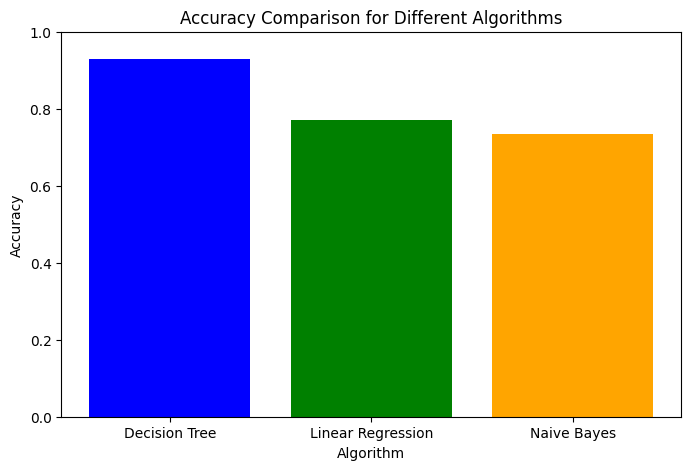

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary with your accuracy values
data = {
    'Algorithm': ['Decision Tree', 'Linear Regression', 'Naive Bayes'],
    'Accuracy': [0.9299, 0.7709, 0.7345]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the table
print(df)

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(df['Algorithm'], df['Accuracy'], color=['blue', 'green', 'orange'])
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison for Different Algorithms')
plt.ylim(0, 1)  # Set the y-axis limits to match accuracy values (0 to 1)
plt.show()
